# TF-IDF heatmaps

We'll try to combine the methods explored in the Data Exploration and Front Page Heatmaps notebooks to generate heatmaps of the use of certain language across newspapers.

In [17]:
load_notebook('./import_me.ipynb')

importing


<module 'da39a3ee5e6b4b0d3255bfef95601890afd80709' from './import_me.ipynb'>

In [13]:
from jupyter_cms.loader import load_notebook

eda = load_notebook('./data_exploration.ipynb')

df, newspapers = eda.load_data()

In [5]:
import utils
import matplotlib.pyplot as plt
%matplotlib inline

In [213]:
import imp
imp.reload(utils)

<module 'utils' from '/Users/sam/workspace/news/analysis/utils.py'>

In [98]:
import numpy as np

MIN_WIDTH = df.page_width_round.min()
MAX_HEIGHT = int(np.ceil((df.page_height_round * (float(MIN_WIDTH) / df.page_width_round)).max()))

print('''The smallest newspaper in the dataset has width {}. We will scale all the newspapers to have the same width.

We'll also pad all the newspapers to have the same height.
The longest height after scaling to the min width is {}.'''.format(
    MIN_WIDTH,
    MAX_HEIGHT
))

The smallest newspaper in the dataset has width 628. We will scale all the newspapers to have the same width.

We'll also pad all the newspapers to have the same height.
The longest height after scaling to the min width is 1412.


In [14]:
df['bow'] = df.text.apply(eda.bag_of_words)

In [208]:
import numpy as np
from scipy.misc import imresize

def intensity_for_paper(paper, desired_width=MIN_WIDTH, desired_height=MAX_HEIGHT):
    paper_height, paper_width = paper.page_height_round.iloc[0], paper.page_width_round.iloc[0]
    grid = utils.make_intensity_grid(paper, paper_height, paper_width)
    resized = imresize(grid, float(desired_width)/paper_width)
    
    scaled_height = resized.shape[0]
    resized.resize(desired_height, desired_width)
    
    # offset to pad at 0s instead
    height_offset = desired_height - scaled_height
    resized[height_offset:] = resized[:scaled_height]
    resized[:height_offset] = 0
    
    return resized

def intensity_map_for_query(query, papers_df):
    intensities = []
    papers_with_query = papers_df[papers_df.bow.apply(lambda x: query in x)].groupby(['date', 'slug'])
    for _, paper in papers_with_query:
        intensity = intensity_for_paper(paper)
        intensities.append(intensity)
    
    paper_count = papers_df.groupby(['date', 'slug']).first().shape[0]
    avg_intensity = sum([x / paper_count for x in intensities])
    
    if isinstance(avg_intensity, int):
        zs = np.zeros((MAX_HEIGHT, MIN_WIDTH))
        zs[0, 0] = .2 # so they're not all zero
        return zs
    
    return avg_intensity

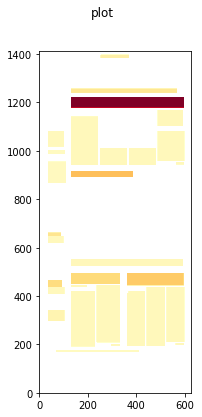

In [93]:
_, paper = next(iter(df.groupby(['date', 'slug'])))
utils.plot_intensity(intensity_for_paper(paper), 'plot')

In [239]:
def plot_mentions_of_query(query, papers_df, imposed_vmax=None):
    intensities = []
    
    vmax = 0
    
    nplots = papers_df.date.nunique()
    
    fig, axs = plt.subplots(3, int(np.ceil(nplots/3)), figsize=(MAX_HEIGHT/100 * 3, MIN_WIDTH/100 * nplots/3))
    for i, (date, df_date) in enumerate(papers_df.groupby('date')):
        intensity = intensity_map_for_query(query.lower(), df_date)
        intensities.append((date, intensity))
        if intensity.max() > vmax:
            vmax = intensity.max()
    
    for i, (date, intensity) in enumerate(intensities):
        utils.plot_intensity(intensity, '{}'.format(date.strftime("%Y-%m-%d")), ax=axs.ravel()[i], vmax=(imposed_vmax or vmax))
    
    plt.suptitle("Mentions of {} from {} to {}".format(query, papers_df.date.min().strftime("%Y-%m-%d"), papers_df.date.max().strftime("%Y-%m-%d")), fontsize=32)
    return vmax

# Tying it all together to make some visualizations:

These graphs weight mentions by font size. A boundary box is drawn around the entire text of the mention. So if the token of interest is "Syria", and a headline says “US BOMBS SYRIA”, then the bounding box for the headline will be given a dark weight. If an article text contains the word “Syria”, then the entire article box will be given a lighter weight, since articles tend to have smaller fonts than headlines.

I didn’t down-weight articles by the length of text, but an argument can be made that a mention of “Syria” in a 300-word article is less meaningful than in a 50-word caption.

28.182432432432449

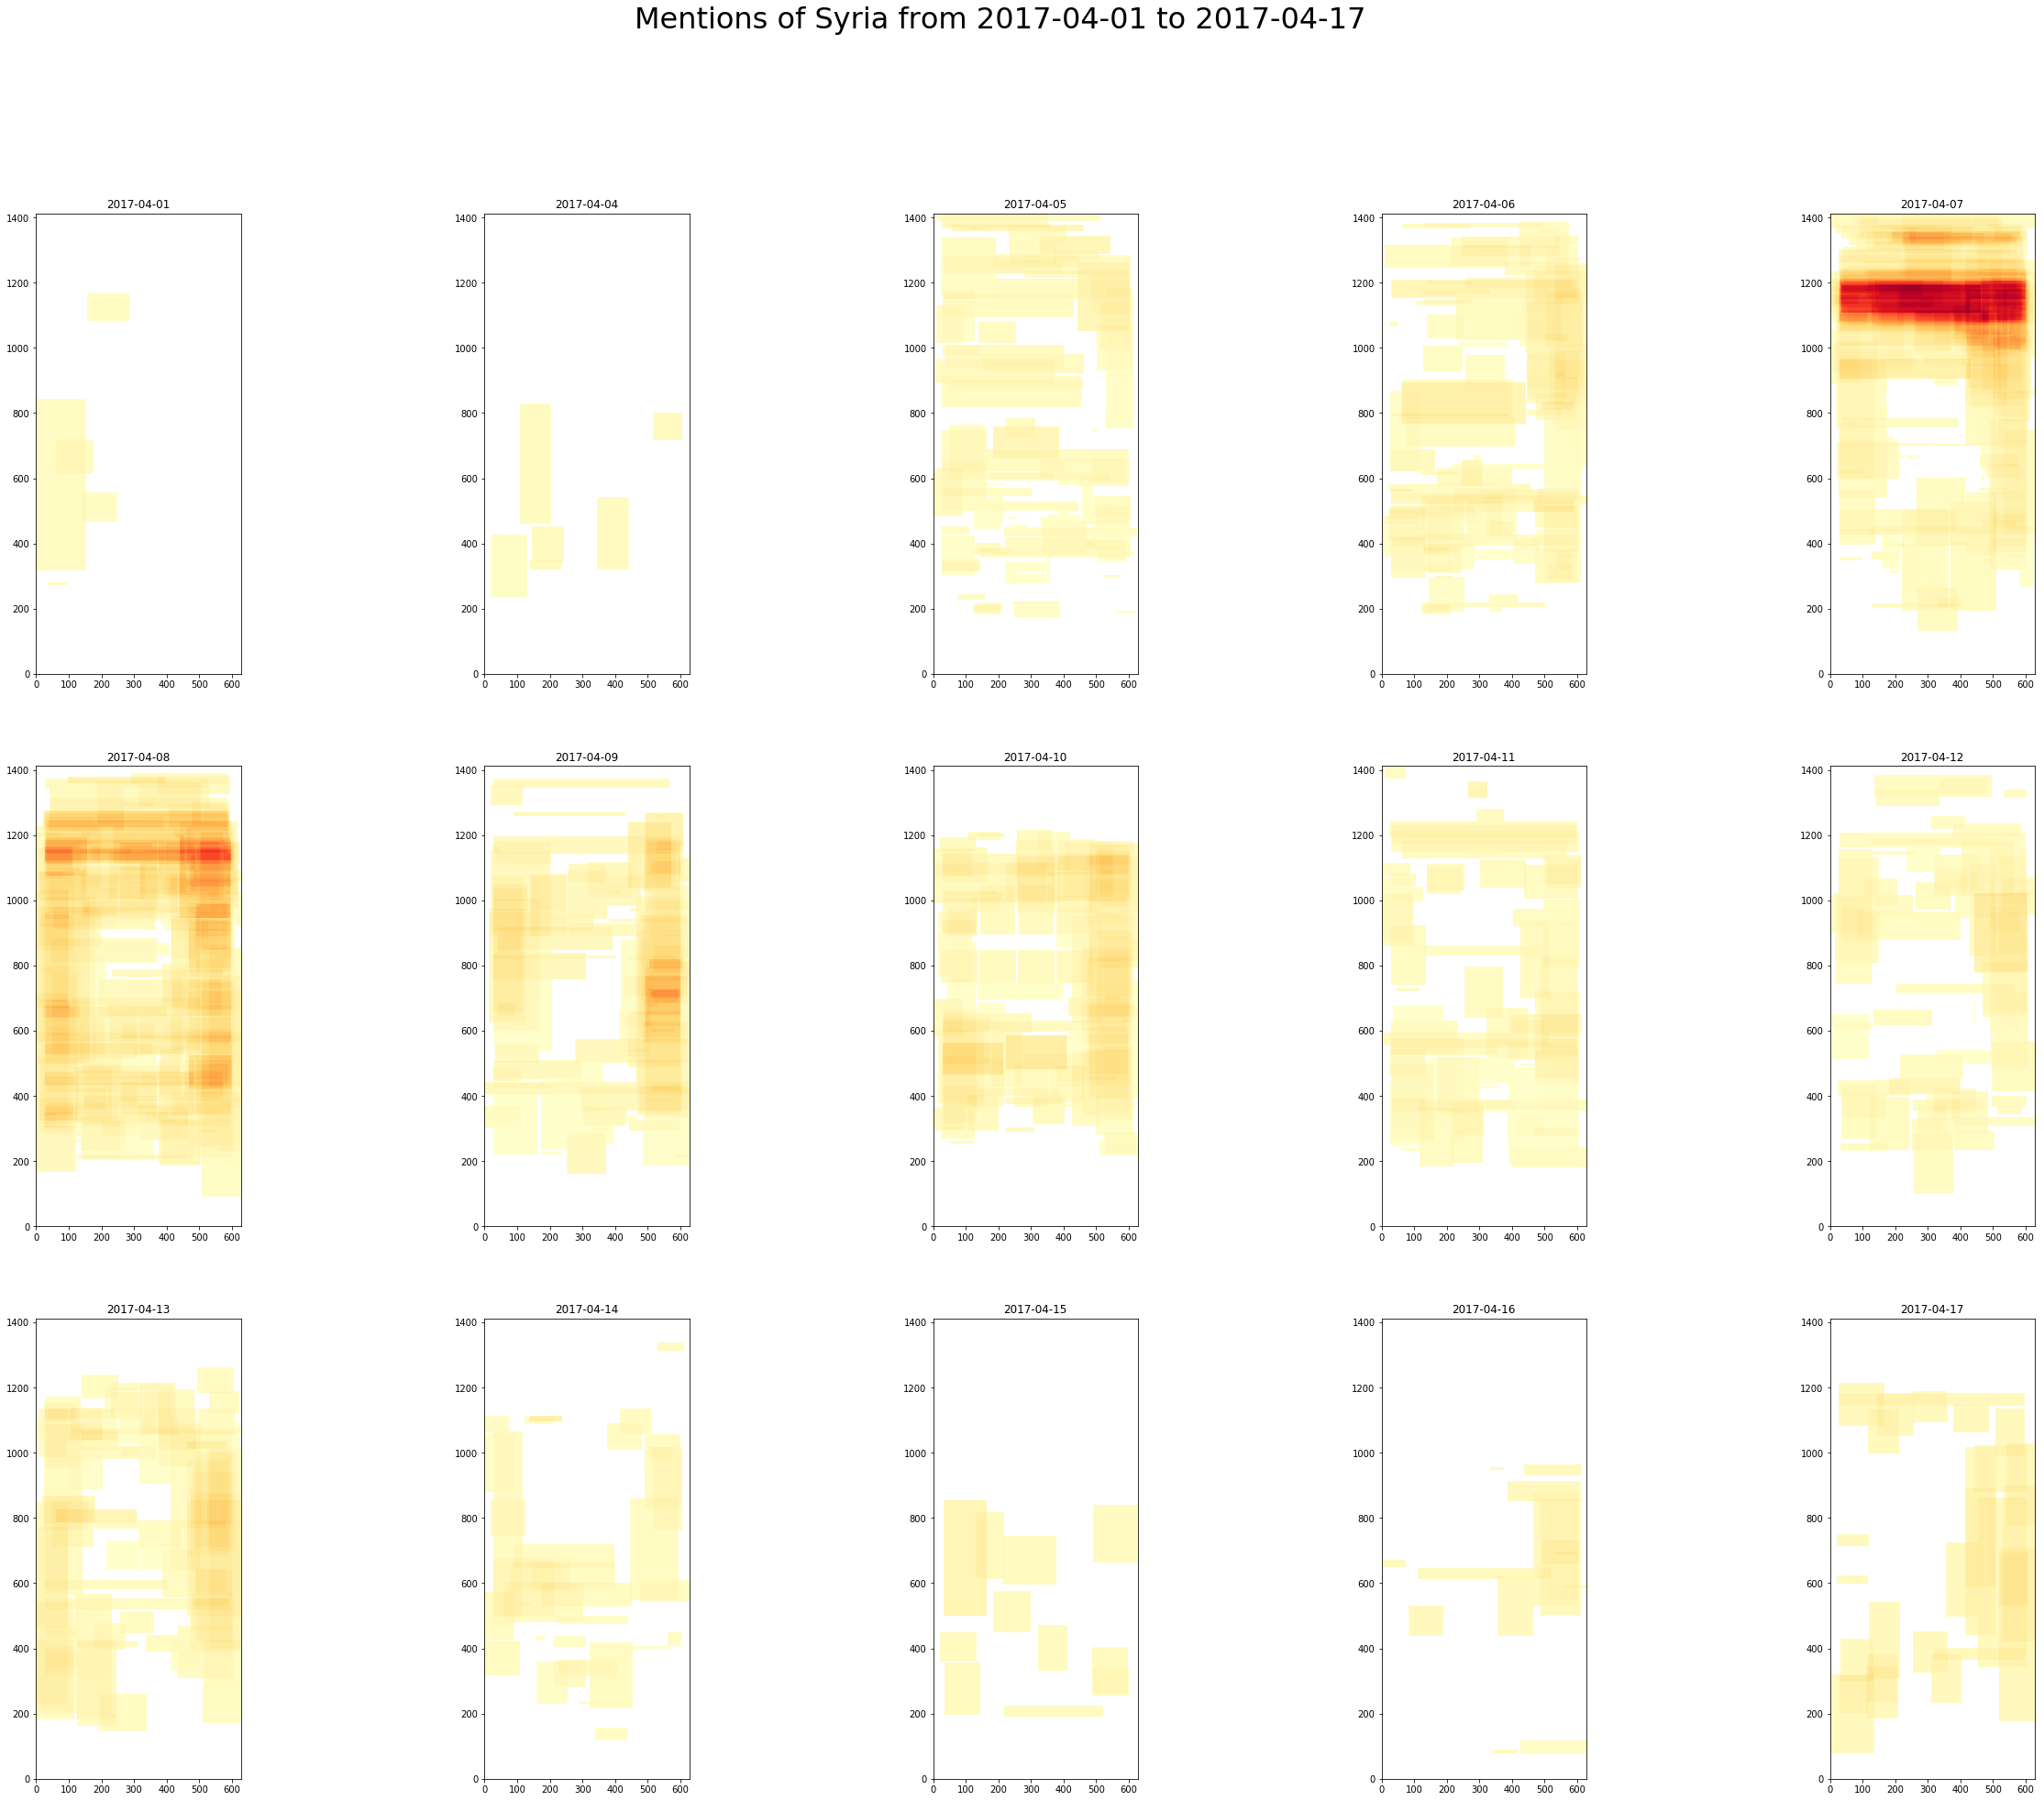

In [240]:
plot_mentions_of_query('Syria', df)

11.806691449814124

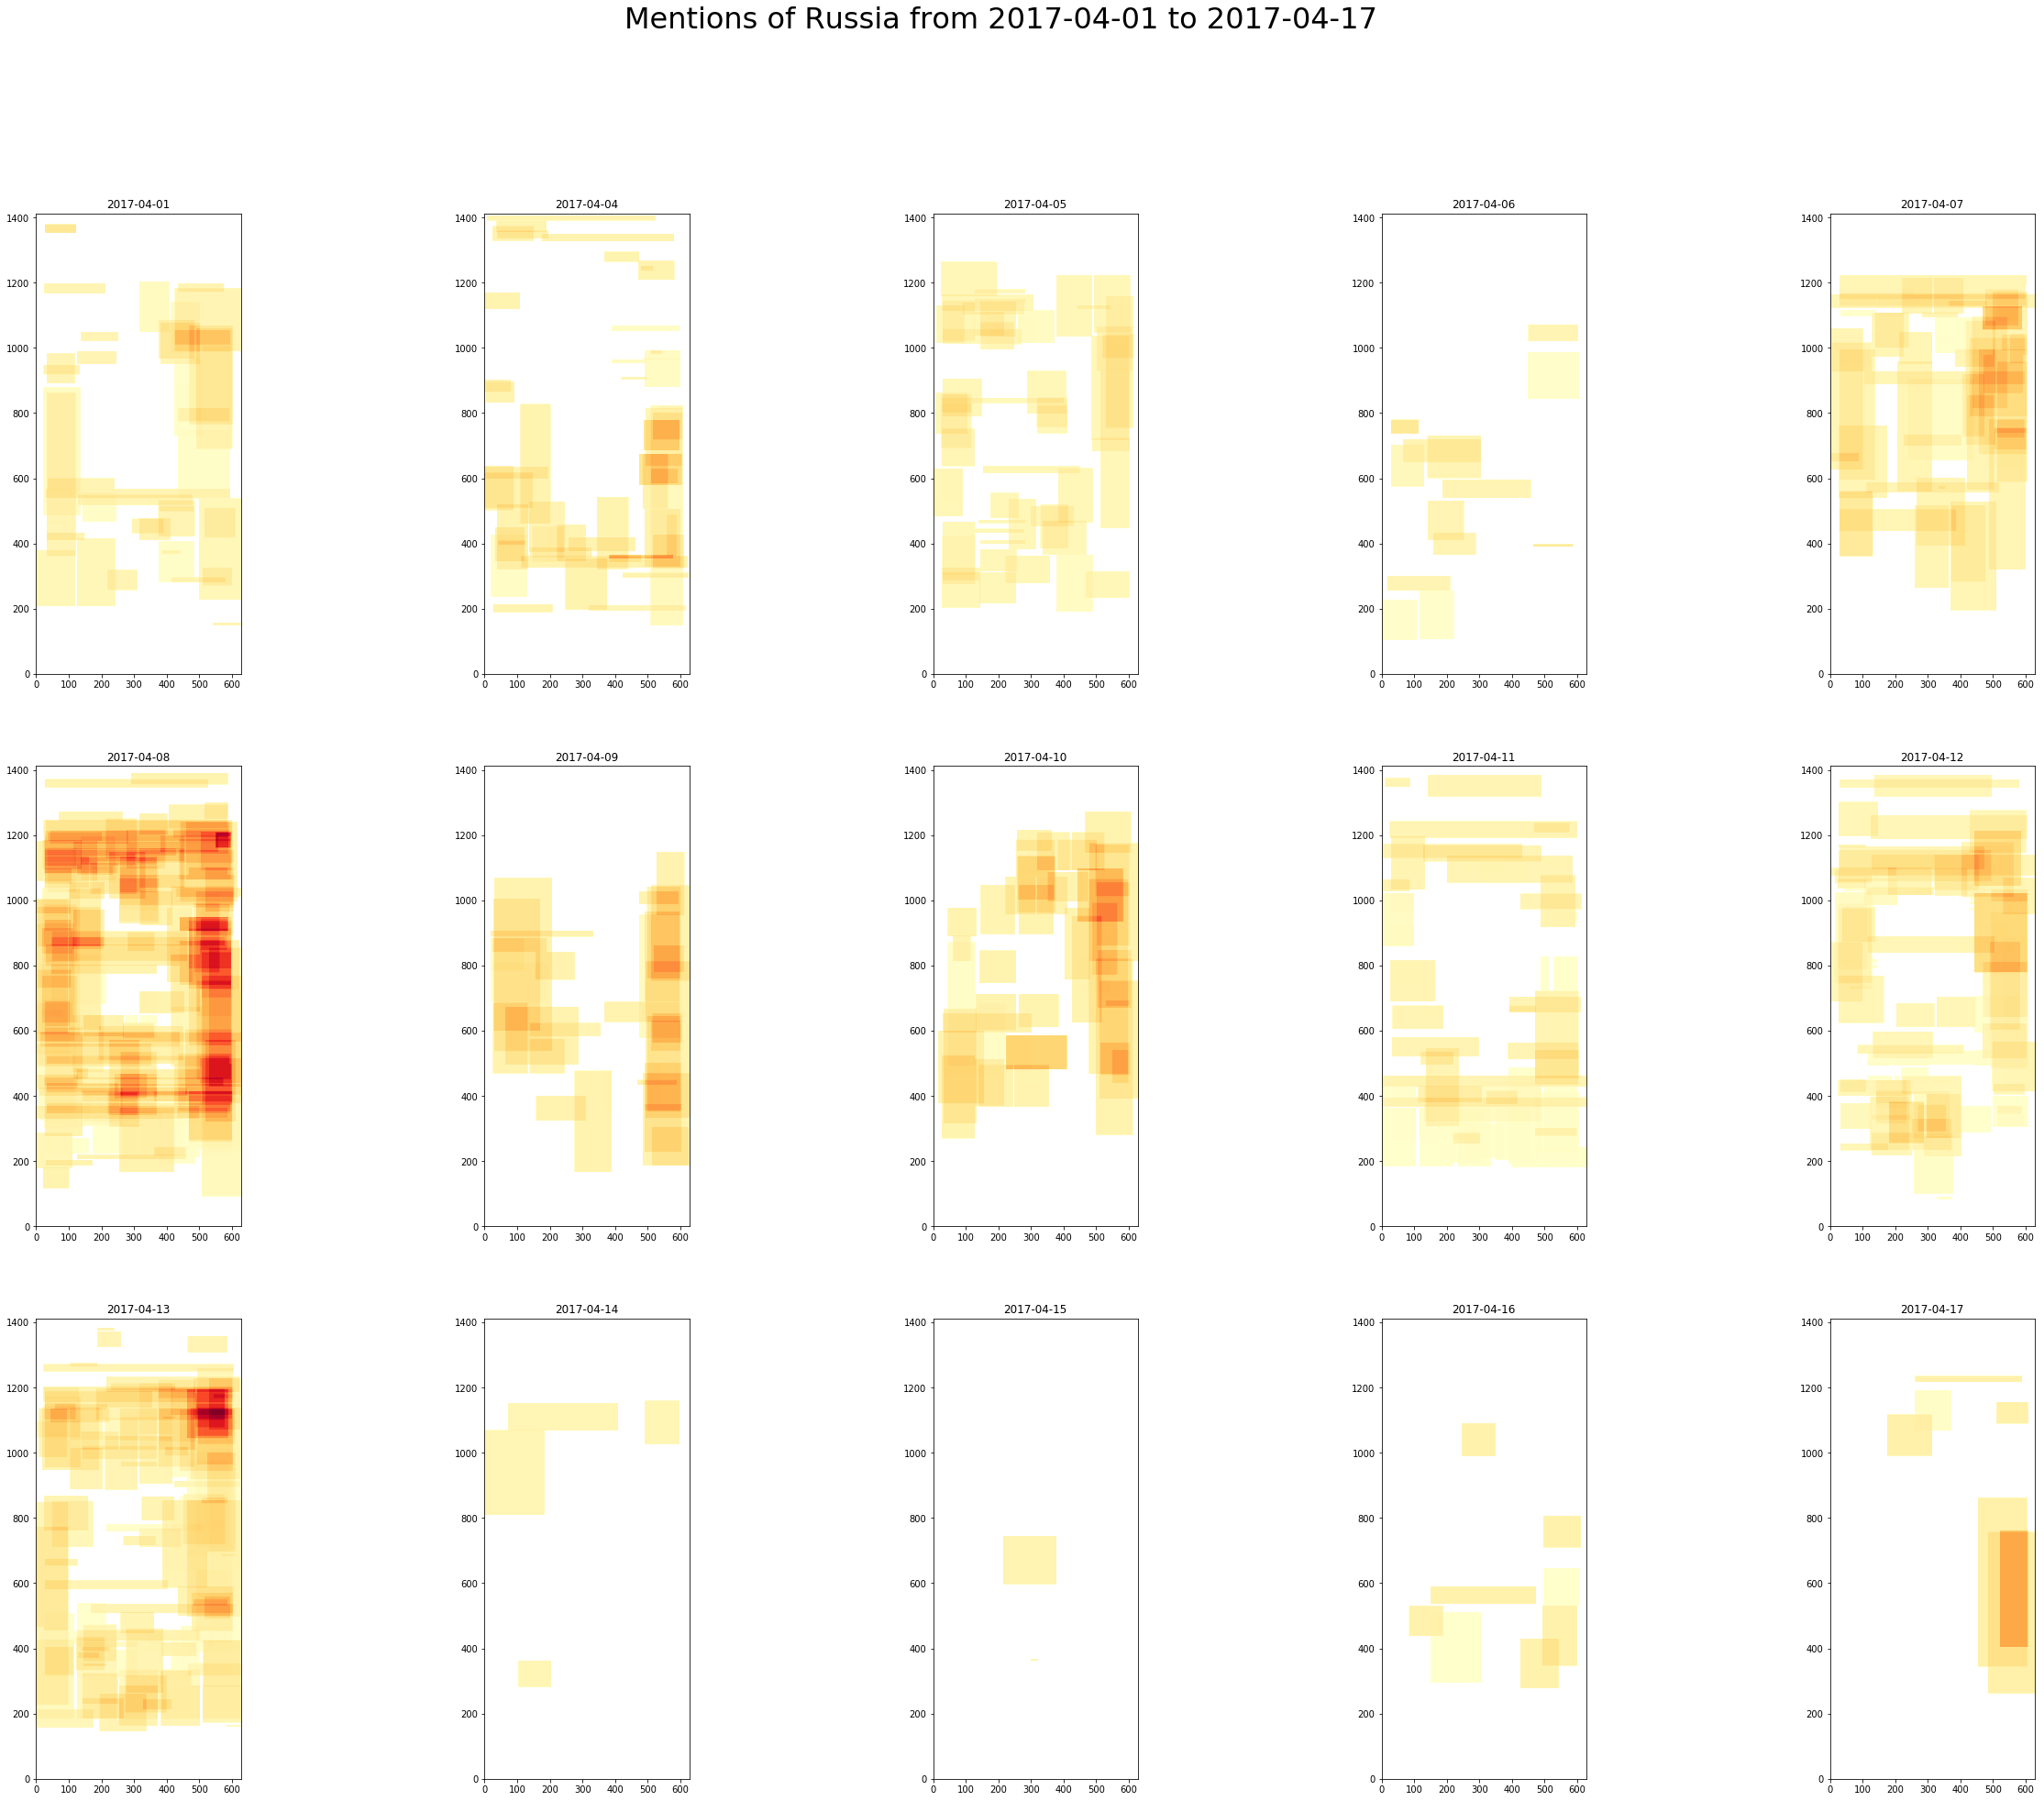

In [242]:
plot_mentions_of_query('Russia', df)

24.258196721311474

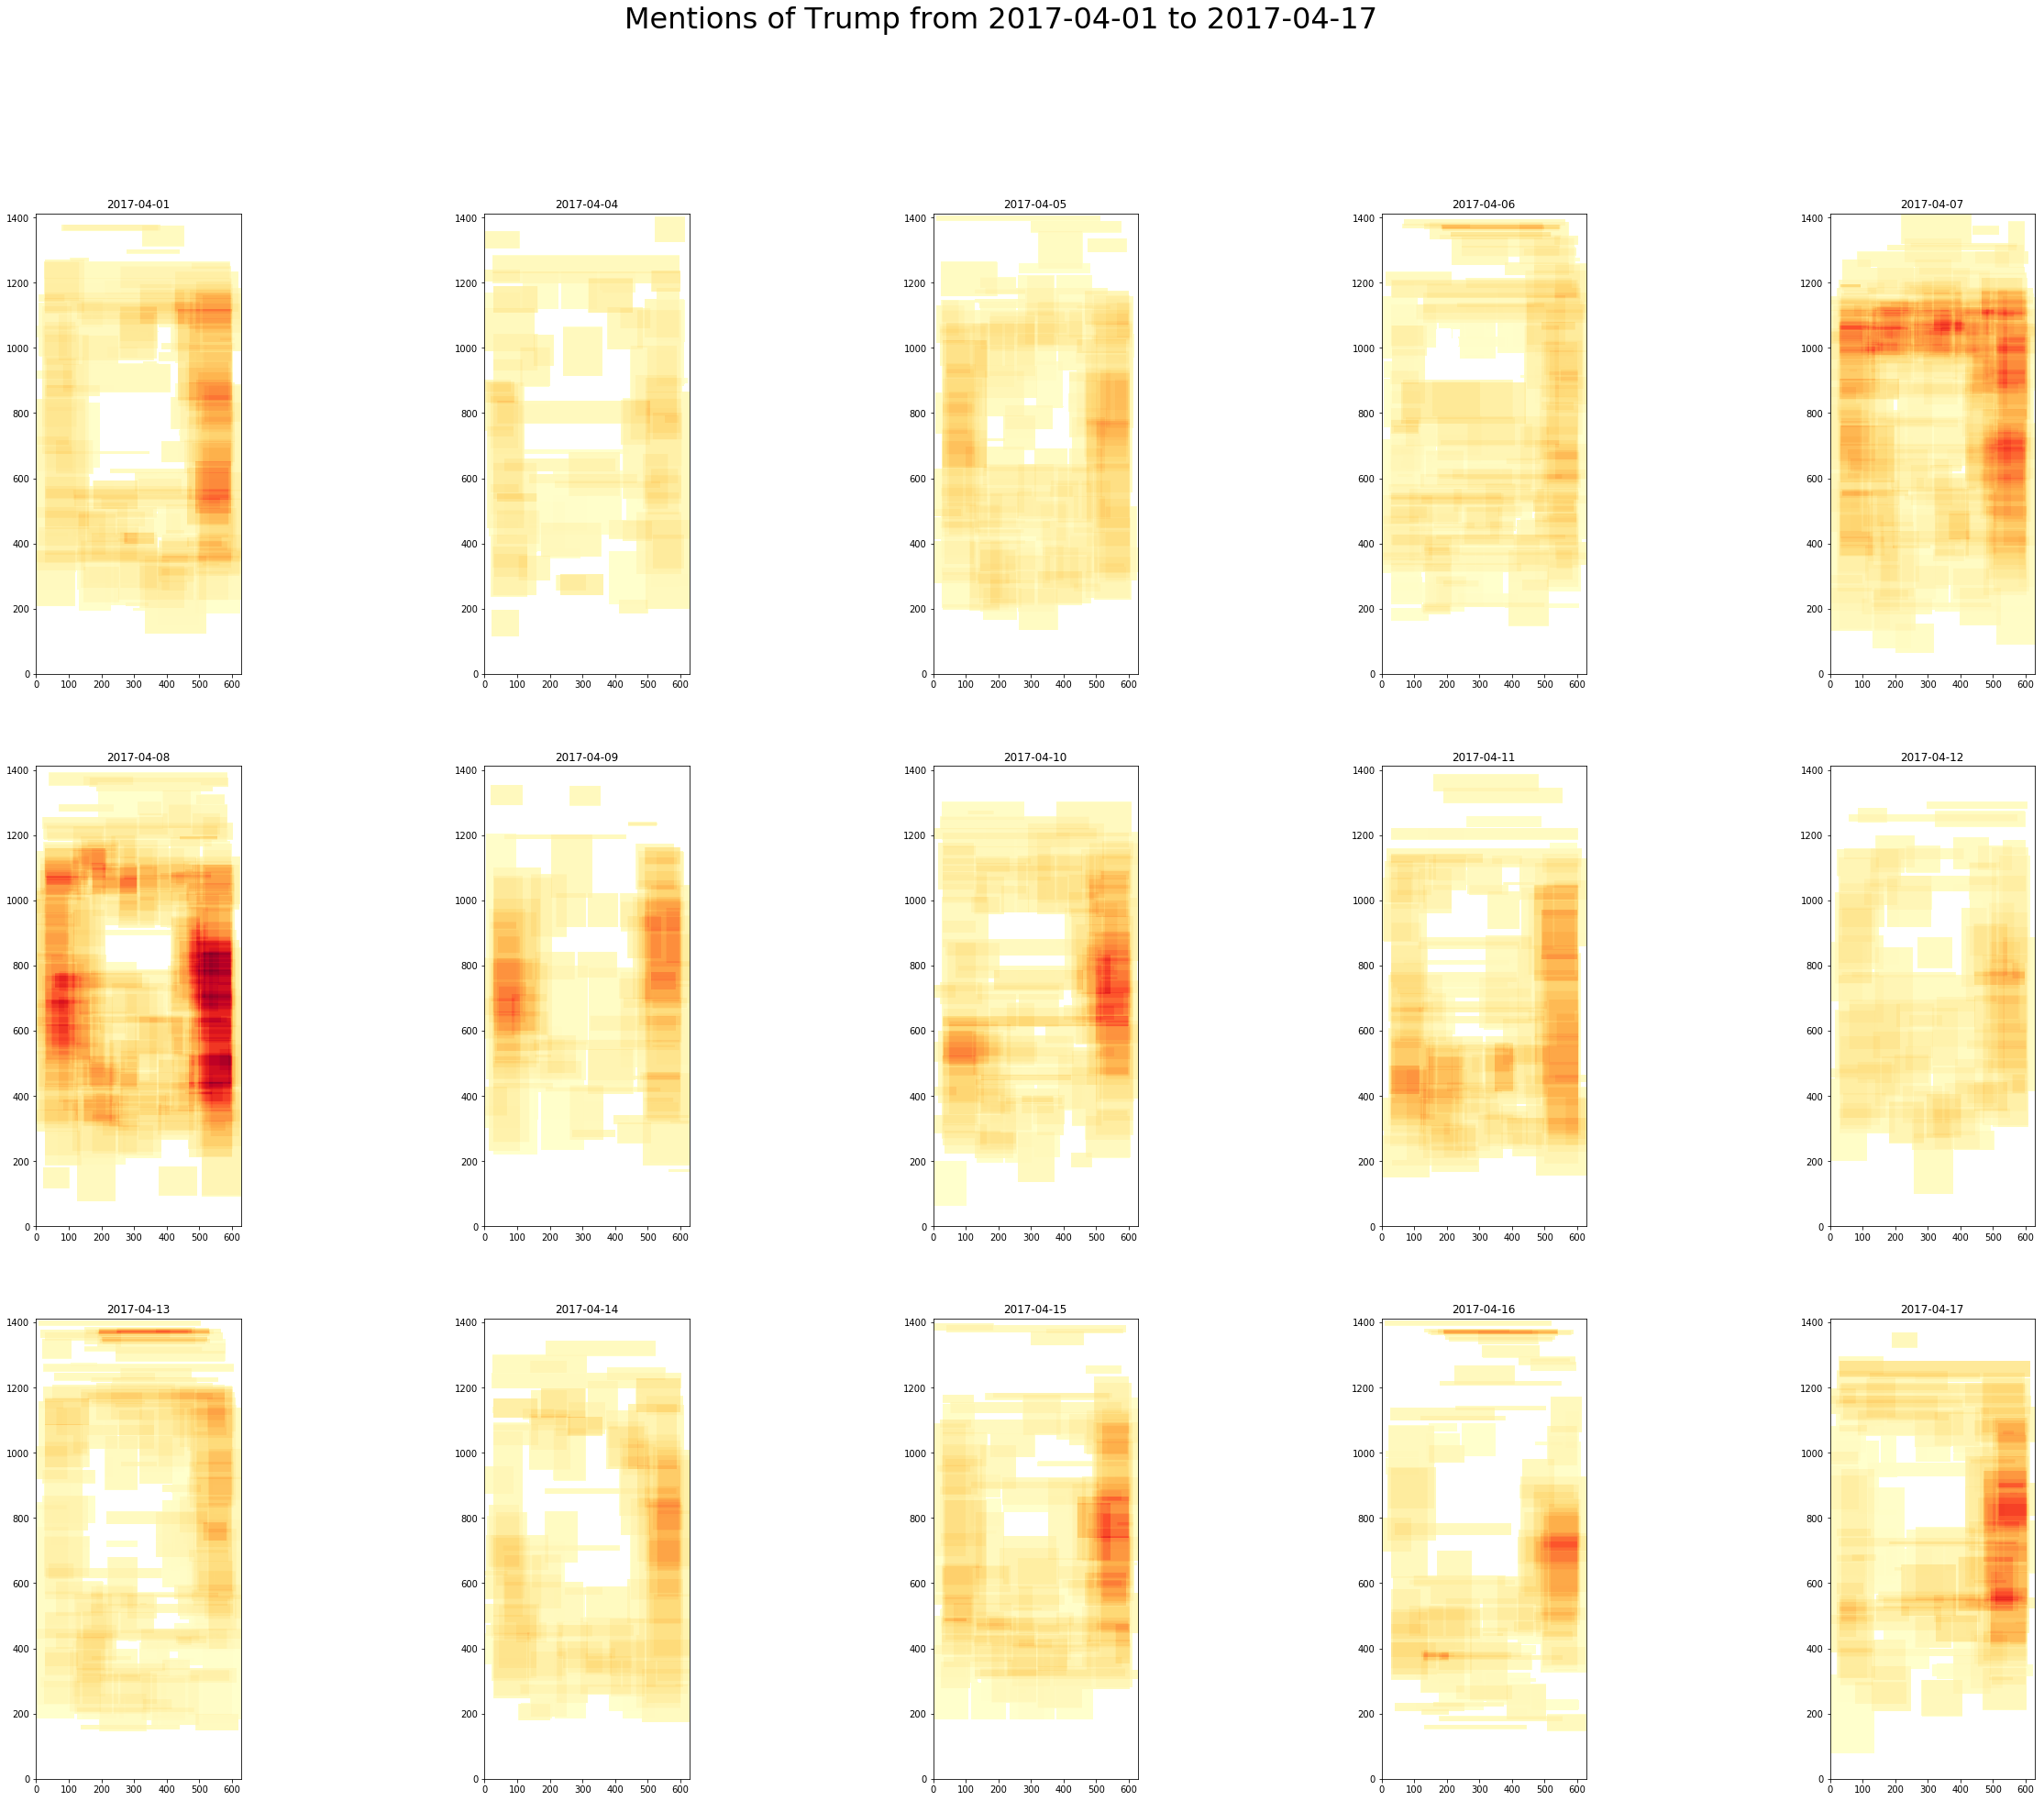

In [241]:
plot_mentions_of_query('Trump', df)

21.352173913043487

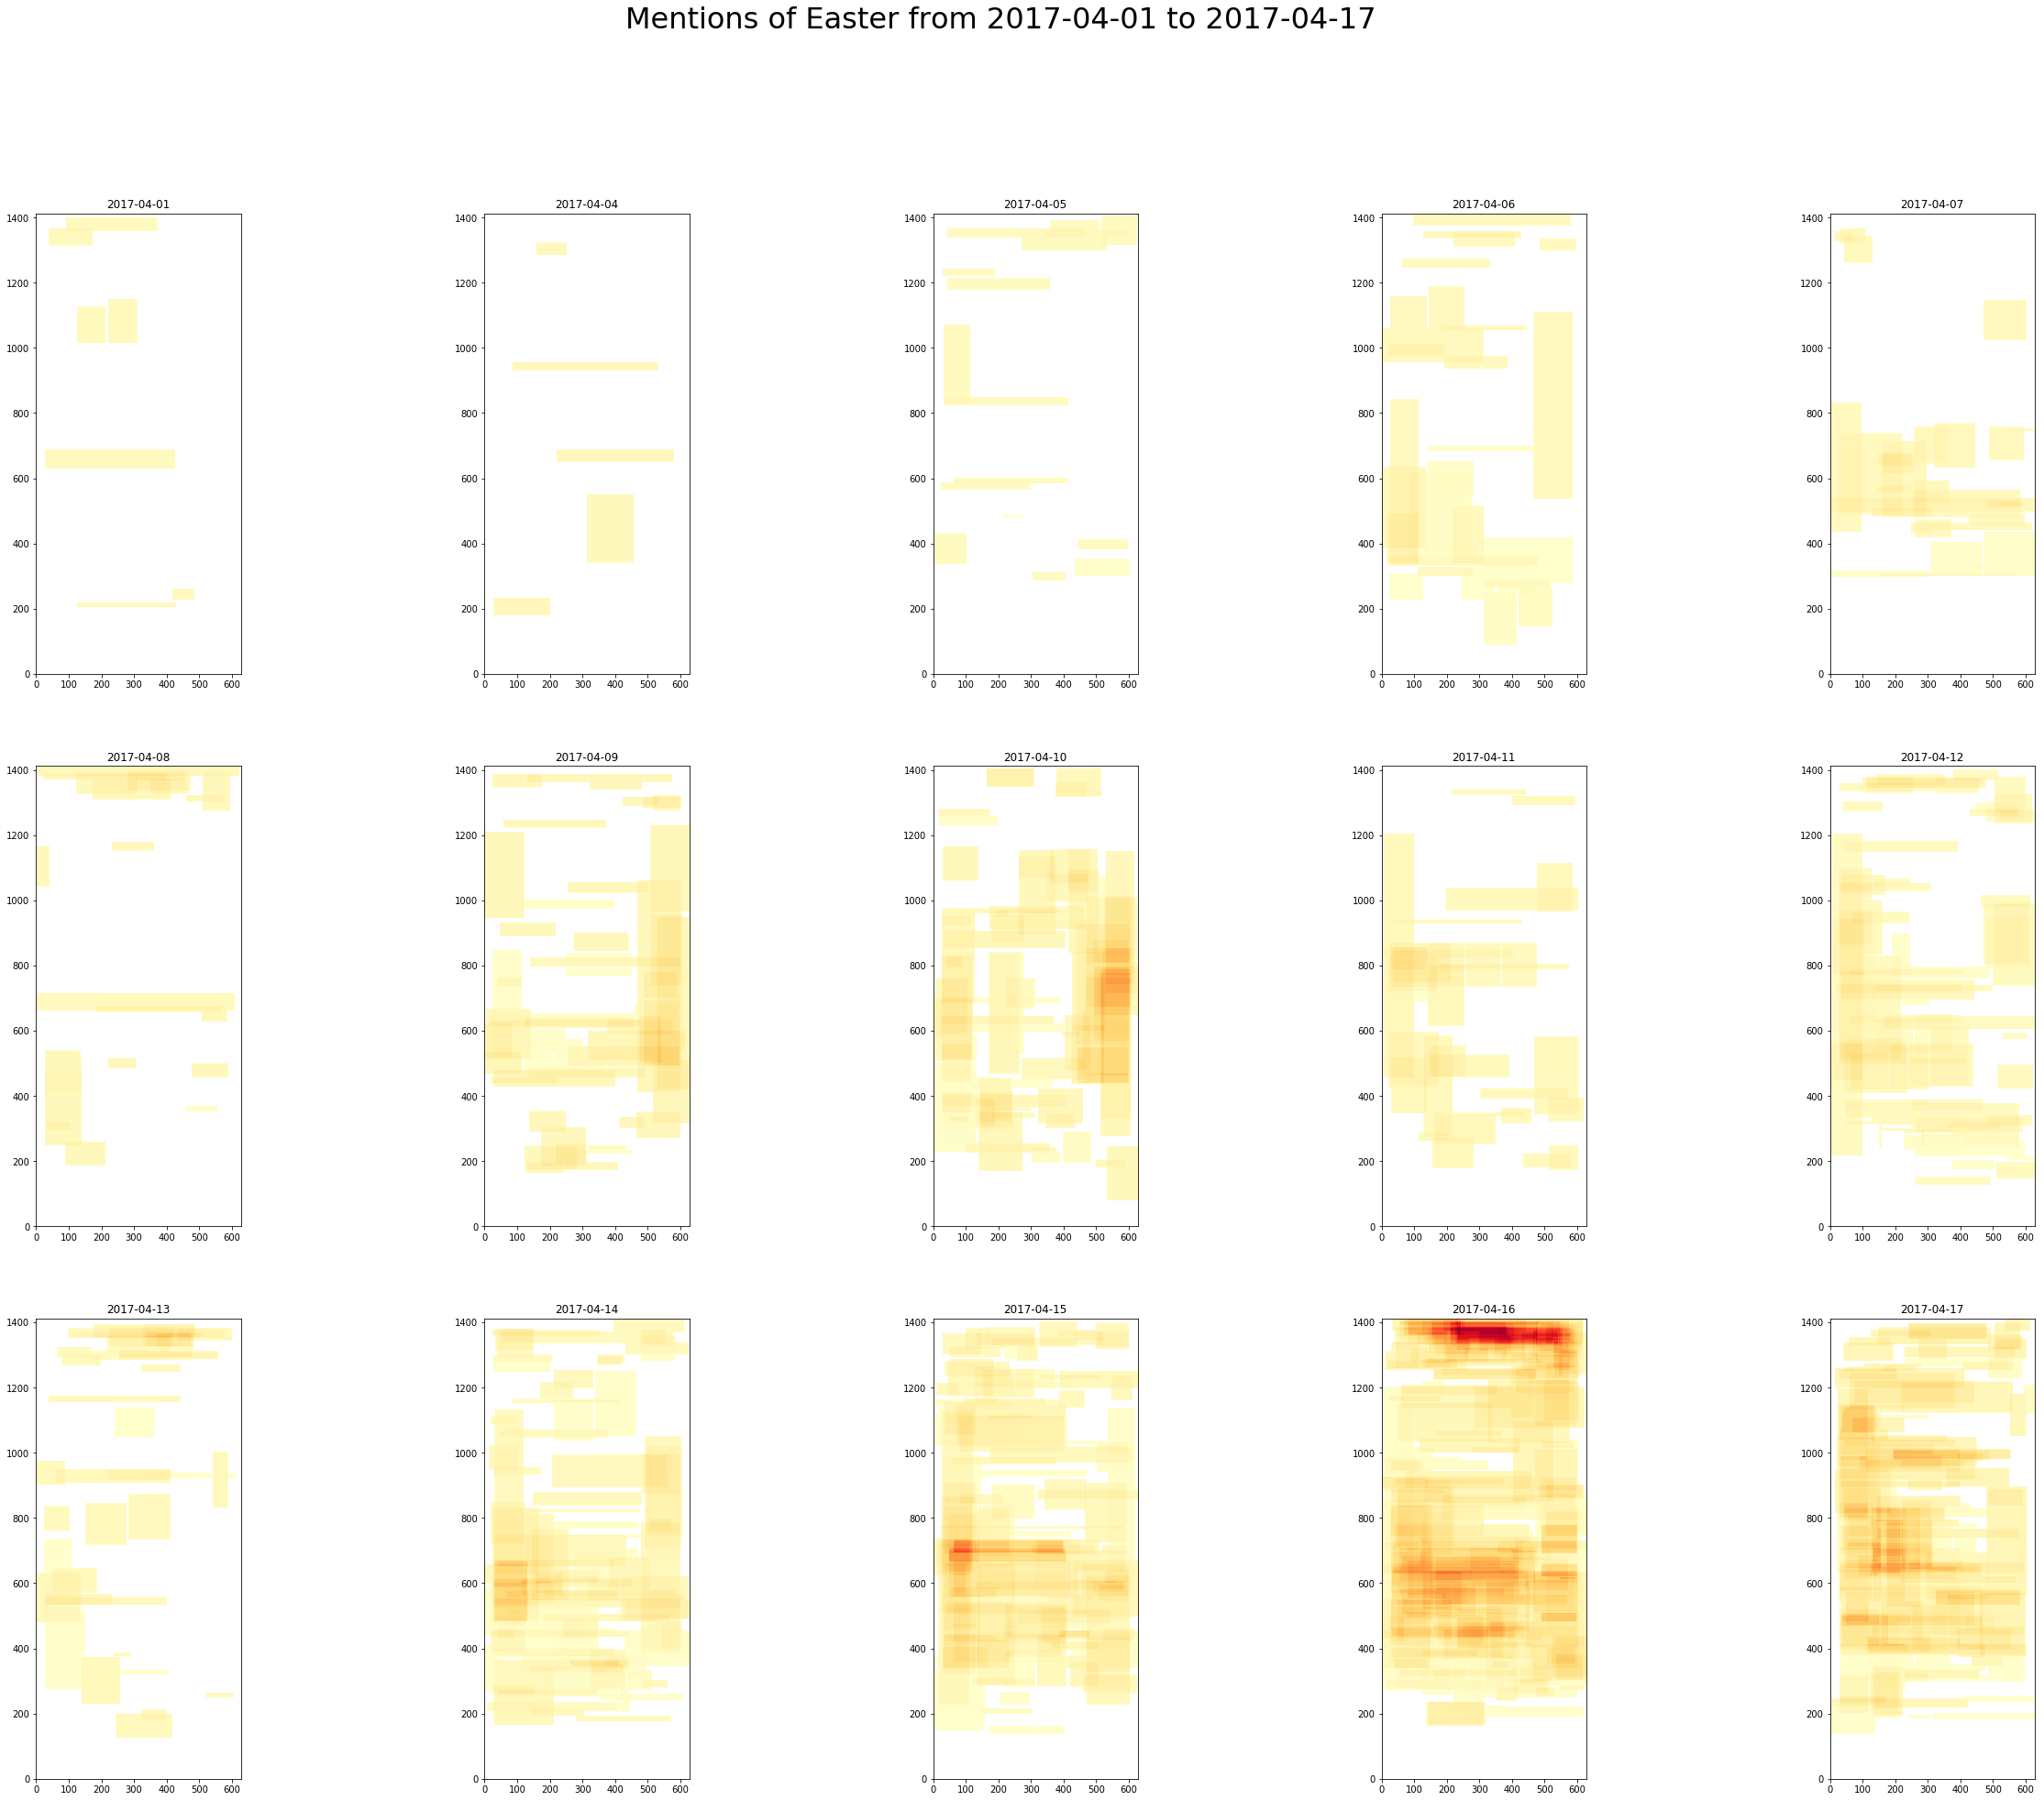

In [243]:
plot_mentions_of_query('Easter', df)